1

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [47]:
df = pd.read_csv('data/processed/master_file_annuel.csv')
df['annee'] = df['annee'].astype(int)

# On filtre à partir de 2010 (début de la VaD et du Replay pour l'Axe 1)
df_subst = df[df['annee'] >= 2010].copy()

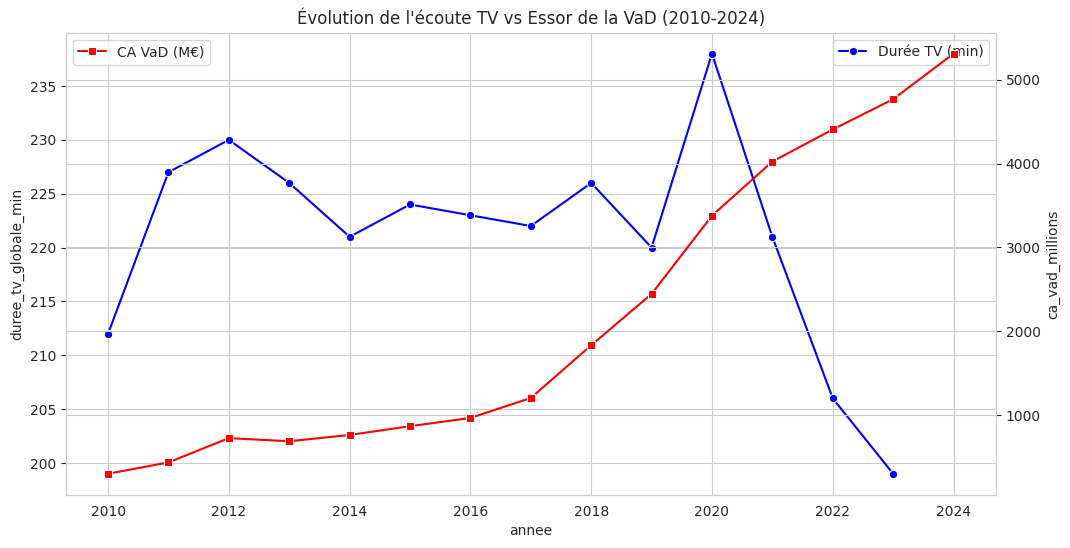

In [48]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_subst, x='annee', y='duree_tv_globale_min', label='Durée TV (min)', color='blue', marker='o')
ax2 = plt.twinx()
sns.lineplot(data=df_subst, x='annee', y='ca_vad_millions', label='CA VaD (M€)', color='red', marker='s', ax=ax2)
plt.title("Évolution de l'écoute TV vs Essor de la VaD (2010-2024)")
plt.show()

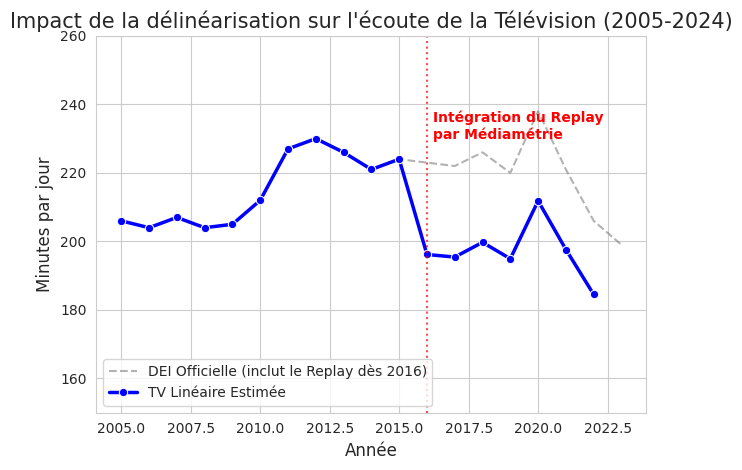

In [49]:
def get_pure_linear(row):
    if row['annee'] >= 2016:
        # Soustraction du poids du replay (Pénétration * Facteur de temps passé)
        correction = (row['taux_replay_pourcent'] / 100) * 0.15
        return row['duree_tv_globale_min'] * (1 - correction)
    return row['duree_tv_globale_min']

df['duree_tv_lineaire_pure'] = df.apply(get_pure_linear, axis=1)

sns.lineplot(data=df[df['annee'] >= 2005], x='annee', y='duree_tv_globale_min',
             label='DEI Officielle (inclut le Replay dès 2016)',
             color='gray', linestyle='--', alpha=0.6)

# Courbe de la donnée corrigée (TV Linéaire Pure)
sns.lineplot(data=df[df['annee'] >= 2005], x='annee', y='duree_tv_lineaire_pure',
             label='TV Linéaire Estimée',
             color='blue', linewidth=2.5, marker='o')

# Mise en évidence du point de rupture de 2016
plt.axvline(x=2016, color='red', linestyle=':', alpha=0.7)
plt.text(2016.2, 230, "Intégration du Replay\npar Médiamétrie", color='red', fontweight='bold')

plt.title("Impact de la délinéarisation sur l'écoute de la Télévision (2005-2024)", fontsize=15)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Minutes par jour", fontsize=12)
plt.legend(loc='lower left')
plt.ylim(150, 260) # Ajuste selon tes données pour bien voir la cassure

plt.tight_layout()
plt.show()

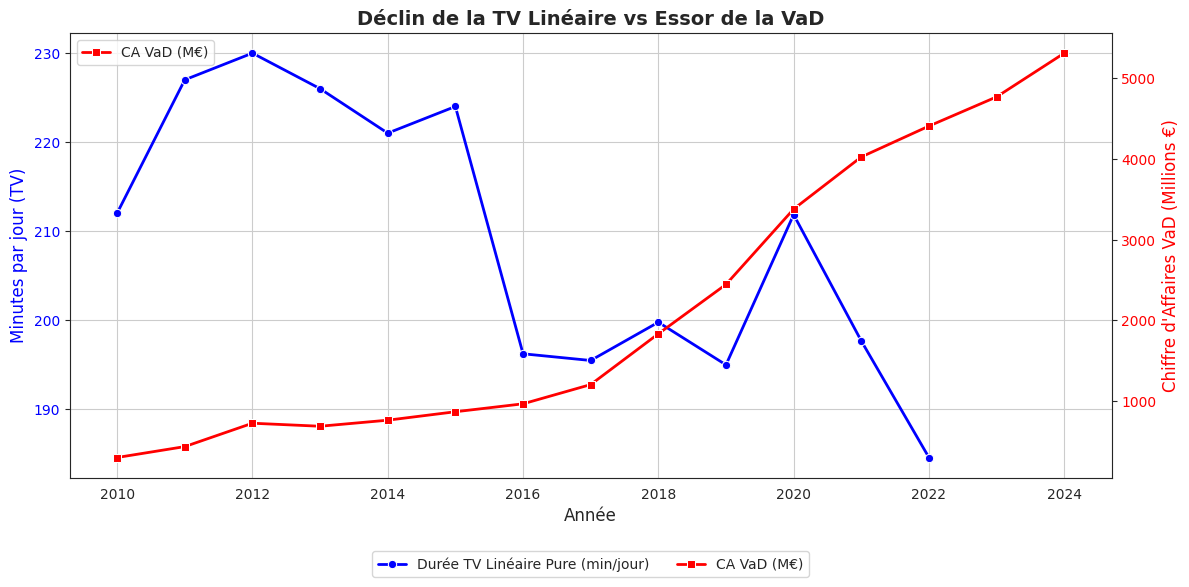

In [50]:
df = pd.read_csv('data/processed/master_file_annuel.csv')

# 2. Définition de la fonction de correction (si pas déjà faite dans une cellule précédente)
def get_pure_linear(row):
    if row['annee'] >= 2016:
        # On retire l'impact du Replay (environ 15% du temps pour les utilisateurs du replay)
        correction = (row['taux_replay_pourcent'] / 100) * 0.15
        return row['duree_tv_globale_min'] * (1 - correction)
    return row['duree_tv_globale_min']

# 3. CRÉATION DE LA COLONNE SUR LE DATAFRAME PRINCIPAL
df['duree_tv_lineaire_pure'] = df.apply(get_pure_linear, axis=1)

# 4. CRÉATION DE LA COPIE FILTRÉE (Après avoir ajouté la colonne)
df_subst = df[df['annee'] >= 2010].copy()

# 5. GÉNÉRATION DU GRAPHIQUE
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.set_style("white")

# Courbe de la Durée TV Pure (Axe gauche)
sns.lineplot(data=df_subst, x='annee', y='duree_tv_lineaire_pure',
             label='Durée TV Linéaire Pure (min/jour)',
             color='blue', marker='o', ax=ax1, linewidth=2)

ax1.set_ylabel('Minutes par jour (TV)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Année', fontsize=12)

# Courbe du CA VaD (Axe droit)
ax2 = ax1.twinx()
sns.lineplot(data=df_subst, x='annee', y='ca_vad_millions',
             label='CA VaD (M€)',
             color='red', marker='s', ax=ax2, linewidth=2)

ax2.set_ylabel('Chiffre d\'Affaires VaD (Millions €)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red') # Correction du labelcolor ici

# Titre et légendes
plt.title("Déclin de la TV Linéaire vs Essor de la VaD", fontsize=14, fontweight='bold')

# Fusion des légendes des deux axes pour les mettre en bas
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.tight_layout()
plt.show()

In [51]:
df_reg = df[df['annee'] >= 2010].dropna(subset=['duree_tv_lineaire_pure', 'ca_vad_millions'])

Y = df_reg['duree_tv_lineaire_pure']
X = df_reg[['ca_vad_millions', 'taux_replay_pourcent']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

# 4. Affichage des résultats
print("--- RÉSULTATS DE LA RÉGRESSION (TV LINÉAIRE CORRIGÉE) ---")
print(model.summary())

--- RÉSULTATS DE LA RÉGRESSION (TV LINÉAIRE CORRIGÉE) ---
                              OLS Regression Results                              
Dep. Variable:     duree_tv_lineaire_pure   R-squared:                       0.532
Model:                                OLS   Adj. R-squared:                  0.439
Method:                     Least Squares   F-statistic:                     5.690
Date:                    Wed, 14 Jan 2026   Prob (F-statistic):             0.0224
Time:                            10:03:20   Log-Likelihood:                -48.428
No. Observations:                      13   AIC:                             102.9
Df Residuals:                          10   BIC:                             104.6
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

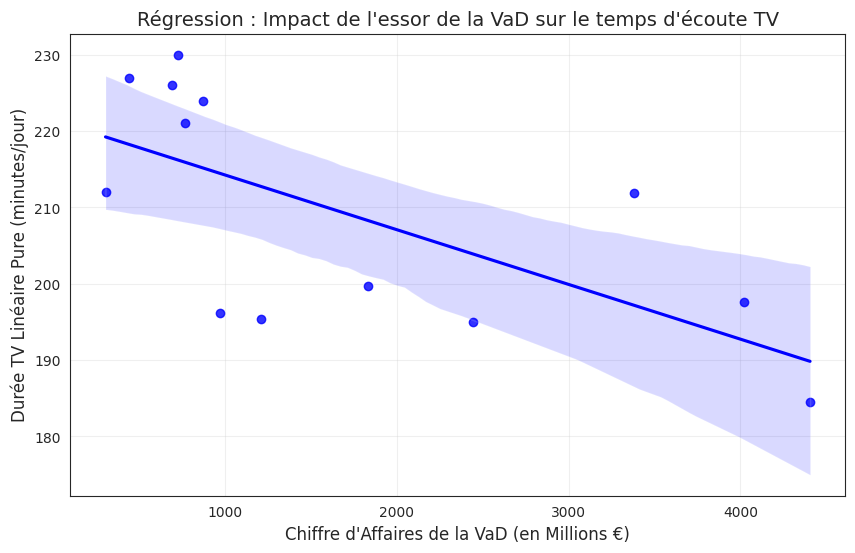

In [52]:
df_plot = df_reg.dropna(subset=['duree_tv_lineaire_pure', 'ca_vad_millions']).copy()

# 2. Création du graphique
plt.figure(figsize=(10, 6))


# On trace la droite de régression
sns.regplot(data=df_plot, x='ca_vad_millions', y='duree_tv_lineaire_pure',
            scatter=True, color='blue', label='Tendance (Régression)')

# Habillage
plt.title("Régression : Impact de l'essor de la VaD sur le temps d'écoute TV", fontsize=14)
plt.xlabel("Chiffre d'Affaires de la VaD (en Millions €)", fontsize=12)
plt.ylabel("Durée TV Linéaire Pure (minutes/jour)", fontsize=12)

# Annotation du coefficient
coef_vad = model.params['ca_vad_millions']


plt.grid(True, alpha=0.3)
plt.show()

2

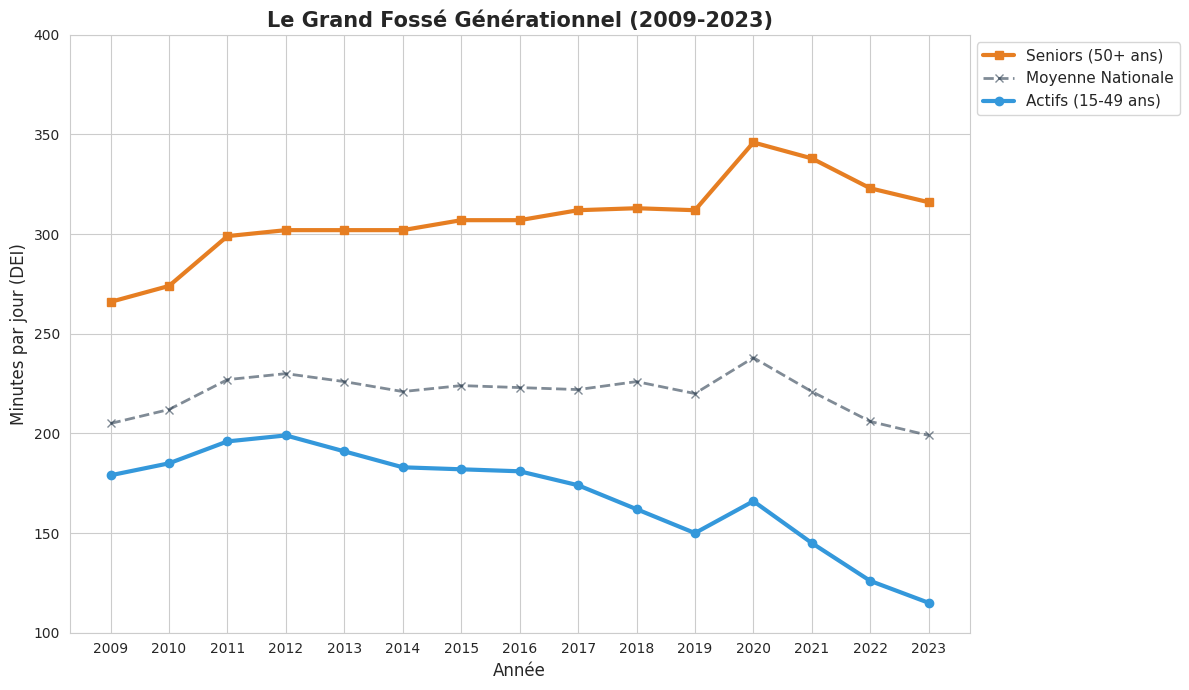

In [60]:
df = pd.read_csv('data/processed/master_file_annuel.csv')

# 2. Filtrage 2009-2023
df['annee'] = df['annee'].astype(int)
df_periode = df[(df['annee'] >= 2009) & (df['annee'] <= 2023)].copy()

# 3. Création du graphique
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# --- Courbe 1 : Les Seniors (50+ ans) ---
# C'est la courbe la plus haute, elle résiste ou augmente
plt.plot(df_periode['annee'], df_periode['duree_tv_50_plus_min'],
         label='Seniors (50+ ans)', color='#e67e22', linewidth=3, marker='s')

# --- Courbe 2 : Moyenne Nationale ---
plt.plot(df_periode['annee'], df_periode['duree_tv_globale_min'],
         label='Moyenne Nationale', color='#2c3e50', linewidth=2, linestyle='--', marker='x', alpha=0.6)

# --- Courbe 3 : Les Actifs (15-49 ans) ---
# C'est la courbe qui décroche le plus
plt.plot(df_periode['annee'], df_periode['duree_tv_15_49_min'],
         label='Actifs (15-49 ans)', color='#3498db', linewidth=3, marker='o')

# Habillage
plt.title("Le Grand Fossé Générationnel (2009-2023)", fontsize=15, fontweight='bold')
plt.xlabel("Année", fontsize=12)
plt.ylabel("Minutes par jour (DEI)", fontsize=12)

# Ajustements des axes
plt.xticks(range(2009, 2024))
plt.ylim(100, 400) # Augmenté car les seniors dépassent souvent les 300 min

# Légende
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)

plt.tight_layout()
plt.show()

In [45]:
df = pd.read_csv('data/processed/master_file_annuel.csv')
# On filtre sur la période où la VaD existe (2010+) et où les données sont complètes
df_reg = df[df['annee'] >= 2010].dropna(subset=['ca_vad_millions', 'duree_tv_15_49_min', 'duree_tv_50_plus_min'])

X = sm.add_constant(df_reg[['ca_vad_millions', 'offre_fiction_pourcent']])

# Modèle 1 : Les 15-49 ans (Cible commerciale / Digitale)
model_jeunes = sm.OLS(df_reg['duree_tv_15_49_min'], X).fit()

# Modèle 2 : Les 50+ (Cible historique / Résiliente)
model_vieux = sm.OLS(df_reg['duree_tv_50_plus_min'], X).fit()

print("=== IMPACT DE LA VAD : JEUNES (15-49) VS VIEUX (50+) ===")
print(f"Coef VaD sur 15-49 ans : {model_jeunes.params['ca_vad_millions']:.4f} min/M€")
print(f"Coef VaD sur 50+ ans   : {model_vieux.params['ca_vad_millions']:.4f} min/M€")
print("-" * 50)
print(f"R-squared 15-49 ans    : {model_jeunes.rsquared:.3f}")
print(f"R-squared 50+ ans      : {model_vieux.rsquared:.3f}")

=== IMPACT DE LA VAD : JEUNES (15-49) VS VIEUX (50+) ===
Coef VaD sur 15-49 ans : -0.0143 min/M€
Coef VaD sur 50+ ans   : 0.0100 min/M€
--------------------------------------------------
R-squared 15-49 ans    : 0.888
R-squared 50+ ans      : 0.658


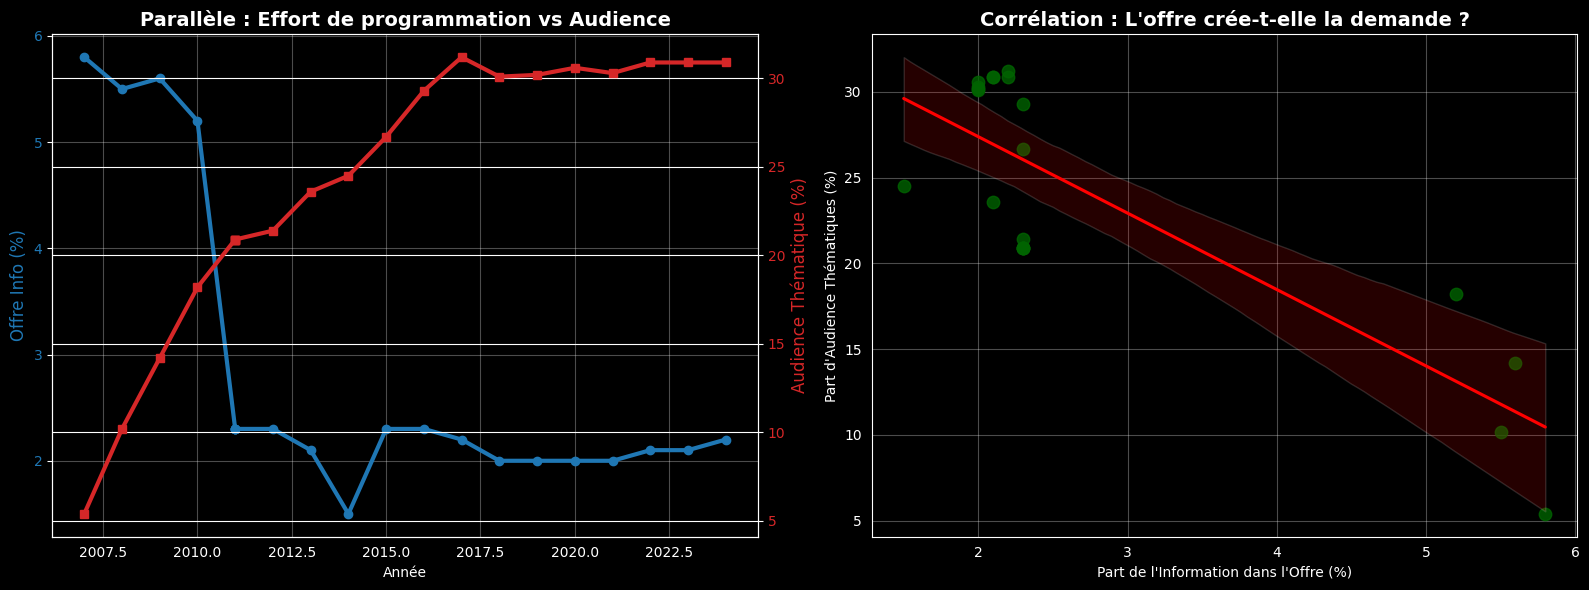

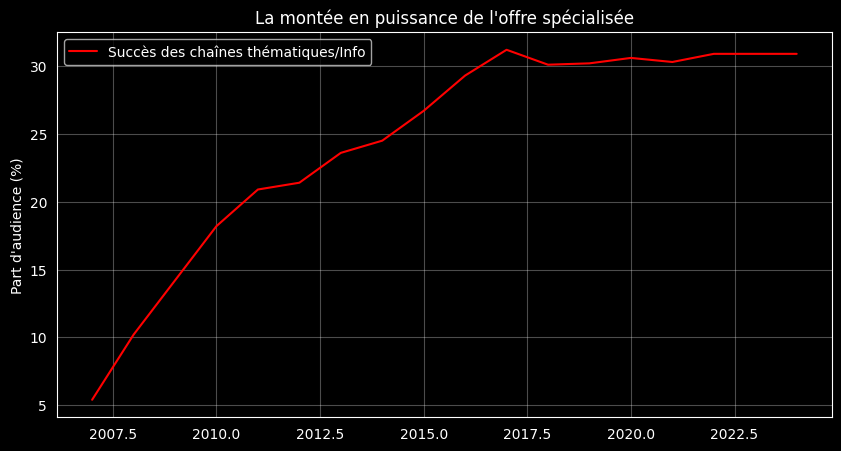

In [14]:
# Chargement du master
df = pd.read_csv('data/processed/master_file_annuel.csv')

# On ne garde que les données exploitables pour l'info (souvent à partir de 2005/2010)
df_plot = df.dropna(subset=['offre_info_pourcent', 'pda_thematiques'])

# Création de la figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- GRAPHIQUE A : Évolution Temporelle (Double axe) ---
color_off = 'tab:blue'
ax1.set_xlabel('Année')
ax1.set_ylabel('Offre Info (%)', color=color_off, fontsize=12)
ax1.plot(df_plot['annee'], df_plot['offre_info_pourcent'], color=color_off, marker='o', linewidth=3, label='Offre Information')
ax1.tick_params(axis='y', labelcolor=color_off)

ax1_twin = ax1.twinx()
color_pda = 'tab:red'
ax1_twin.set_ylabel('Audience Thématique (%)', color=color_pda, fontsize=12)
ax1_twin.plot(df_plot['annee'], df_plot['pda_thematiques'], color=color_pda, marker='s', linewidth=3, label='PDA Thématiques')
ax1_twin.tick_params(axis='y', labelcolor=color_pda)

ax1.set_title("Parallèle : Effort de programmation vs Audience", fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# --- GRAPHIQUE B : Nuage de points et Droite de Régression ---
sns.regplot(x='offre_info_pourcent', y='pda_thematiques', data=df_plot, ax=ax2,
            scatter_kws={'s': 80, 'color': 'darkgreen'}, line_kws={'color': 'red'})
ax2.set_title("Corrélation : L'offre crée-t-elle la demande ?", fontsize=14, fontweight='bold')
ax2.set_xlabel('Part de l\'Information dans l\'Offre (%)')
ax2.set_ylabel('Part d\'Audience Thématiques (%)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(df['annee'], df['pda_thematiques'], color='red', label='Succès des chaînes thématiques/Info')
plt.title("La montée en puissance de l'offre spécialisée")
plt.ylabel("Part d'audience (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

--- RÉSULTATS DE LA RÉGRESSION : STRATÉGIE INFO ---
                            OLS Regression Results                            
Dep. Variable:        pda_thematiques   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     96.78
Date:                Wed, 14 Jan 2026   Prob (F-statistic):           2.34e-10
Time:                        17:23:15   Log-Likelihood:                -45.494
No. Observations:                  21   AIC:                             96.99
Df Residuals:                      18   BIC:                             100.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

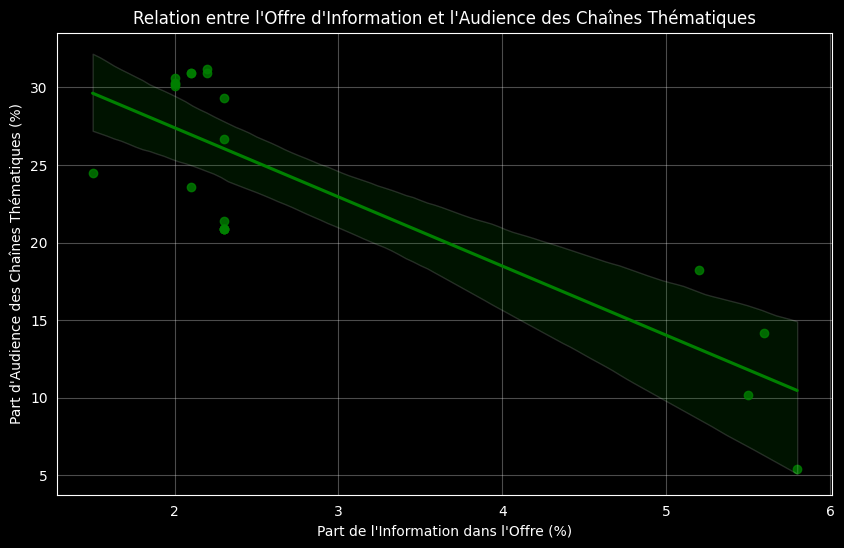

In [13]:
df = pd.read_csv('data/processed/master_file_annuel.csv')

# On filtre les années où nous avons à la fois l'offre info et la PDA
# Généralement pertinent à partir de l'arrivée de la TNT (2005+)
df_strat = df.dropna(subset=['pda_thematiques', 'offre_info_pourcent'])

# 2. Définition des variables
# Y = Part d'audience des chaînes thématiques/info (Demande)
# X = Offre d'information en % du volume horaire (Offre)
Y = df_strat['pda_thematiques']
X = df_strat[['offre_info_pourcent', 'annee']] # On ajoute l'année pour contrôler l'effet temps
X = sm.add_constant(X)

# 3. Exécution du modèle OLS
model_strat = sm.OLS(Y, X).fit()

# 4. Affichage des résultats
print("--- RÉSULTATS DE LA RÉGRESSION : STRATÉGIE INFO ---")
print(model_strat.summary())

# 5. Visualisation de la corrélation
plt.figure(figsize=(10, 6))
sns.regplot(x='offre_info_pourcent', y='pda_thematiques', data=df_strat, color='green')
plt.title('Relation entre l\'Offre d\'Information et l\'Audience des Chaînes Thématiques')
plt.xlabel('Part de l\'Information dans l\'Offre (%)')
plt.ylabel('Part d\'Audience des Chaînes Thématiques (%)')
plt.grid(True, alpha=0.3)
plt.show()

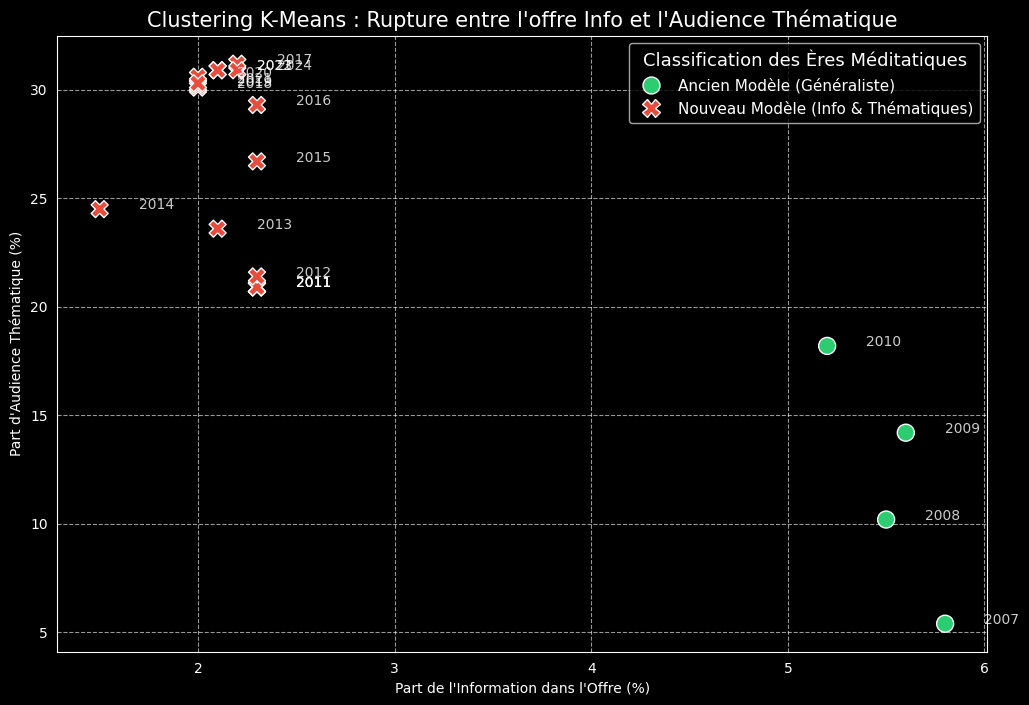

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. On nettoie pour n'avoir que les lignes avec nos deux variables
df_ml = df.dropna(subset=['offre_info_pourcent', 'pda_thematiques']).copy()

# 2. Préparation des données (X = Offre, Y = Audience)
X = df_ml[['offre_info_pourcent', 'pda_thematiques']]

# Normalisation : indispensable car les échelles peuvent différer
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. K-Means avec 2 clusters (les deux zones que tu as repérées)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df_ml['cluster'] = kmeans.fit_predict(X_scaled)

noms_clusters = {
    0: "Ancien Modèle (Généraliste)",
    1: "Nouveau Modèle (Info & Thématiques)"
}

# 2. On applique ces noms à une nouvelle colonne
df_ml['Nom_Era'] = df_ml['cluster'].map(noms_clusters)

# 3. On trace le graphique avec Seaborn en utilisant 'Nom_Era'
plt.figure(figsize=(12, 8))

plot = sns.scatterplot(
    data=df_ml,
    x='offre_info_pourcent',
    y='pda_thematiques',
    hue='Nom_Era',      # On utilise la colonne avec les vrais noms
    palette=['#2ecc71', '#e74c3c'], # Vert et Rouge pour bien marquer le contraste
    s=150,Grand Remplacemen
    style='Nom_Era'
)

# On ajoute les années pour la clarté
for i in range(df_ml.shape[0]):
    plt.text(df_ml.offre_info_pourcent.iloc[i]+0.2, df_ml.pda_thematiques.iloc[i],
             int(df_ml.annee.iloc[i]), fontsize=10, alpha=0.8)

# Personnalisation de la légende
plt.legend(title="Classification des Ères Méditatiques", title_fontsize='13', fontsize='11')
plt.title("Clustering K-Means : Rupture entre l'offre Info et l'Audience Thématique", fontsize=15)
plt.xlabel("Part de l'Information dans l'Offre (%)")
plt.ylabel("Part d'Audience Thématique (%)")
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()